In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

VER = 98

# SET TO NONE TO TRAIN NEW MODEL
INFER_FROM_PATH = None

In [2]:
# ORIGINAL TRAIN DATA
train = pd.read_csv('godaddy-microbusiness-density-forecasting/train.csv')
print('Original train data shape:', train.shape )

Original train data shape: (122265, 7)


In [3]:
# EXTRA TRAIN DATA
df = pd.read_csv('godaddy-microbusiness-density-forecasting/revealed_test.csv')
print('Extra train data shape:', df.shape )

Extra train data shape: (6270, 7)


In [4]:
# CONCATENATE TRAIN DATA
train = pd.concat([train,df],axis=0,ignore_index=True)
train.first_day_of_month = pd.to_datetime(train.first_day_of_month)
train = train.sort_values(['cfips','first_day_of_month'])
train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['year'] = train.first_day_of_month.dt.year
print('Concatenated train data shape',train.shape)
train.tail()

Concatenated train data shape (128535, 9)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pop,year
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785396,100,5601.0,2022
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785396,100,5601.0,2022
122264,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785396,100,5601.0,2022
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785396,100,5601.0,2022
128534,56045_2022-12-01,56045,Weston County,Wyoming,2022-12-01,1.803249,101,5601.0,2022


In [5]:
# FIRST DAY, LAST DAY
train.first_day_of_month.min(), train.first_day_of_month.max()

(Timestamp('2019-08-01 00:00:00'), Timestamp('2022-12-01 00:00:00'))

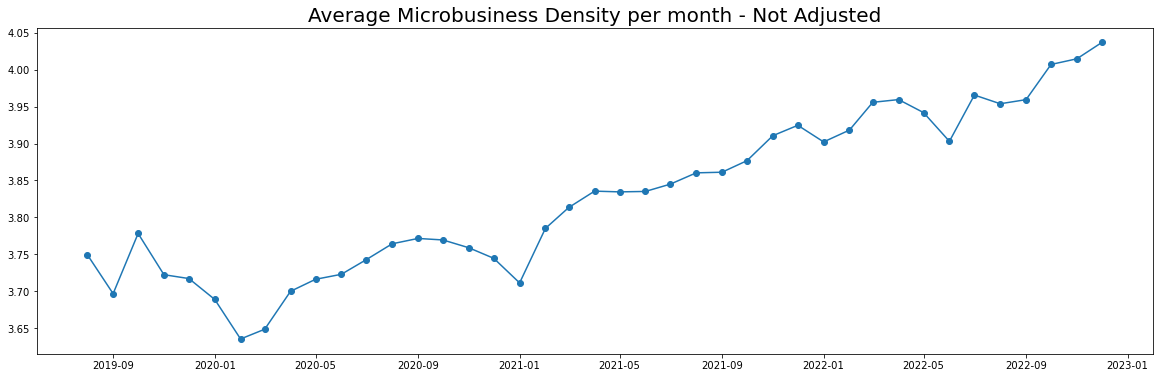

In [6]:
# PLOT AVERAGE MD PER MONTH
tmp = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp.index, tmp,'-o')
plt.title('Average Microbusiness Density per month - Not Adjusted',size=20)
plt.show()

## Adjust All Microbusiness Density to one census
Microbusiness density is defined as microbusinesses per 100 people over the age 18. Therefore microbusiness density changes if the county population changes. To train our model, we will convert each month's microbusiness density to use the same most recent census information. Combine the data from the census.

In [7]:
adults = {}
COLS = ['GEO_ID','NAME','S0101_C01_026E']

for k in [2017,2018,2019,2020,2021]:
    df2021 = pd.read_csv(f'archive/ACSST5Y{k}.S0101-Data.csv',usecols=COLS,low_memory=False)
    df2021 = df2021.iloc[1:]
    df2021['S0101_C01_026E'] = df2021['S0101_C01_026E'].astype('int')
    df2021['cfips'] = df2021.GEO_ID.apply(lambda x: int(x.split('US')[-1]) )
    adults[k] = df2021.set_index('cfips').S0101_C01_026E.to_dict()
    
train['adult2021'] = train.cfips.map(adults[2021])
for k in [2019,2020,2021,2022]:
    train['adults'] = train.cfips.map(adults[k-2])
    train.loc[train.year==k,'microbusiness_density'] *=\
         train.adults / train.adult2021

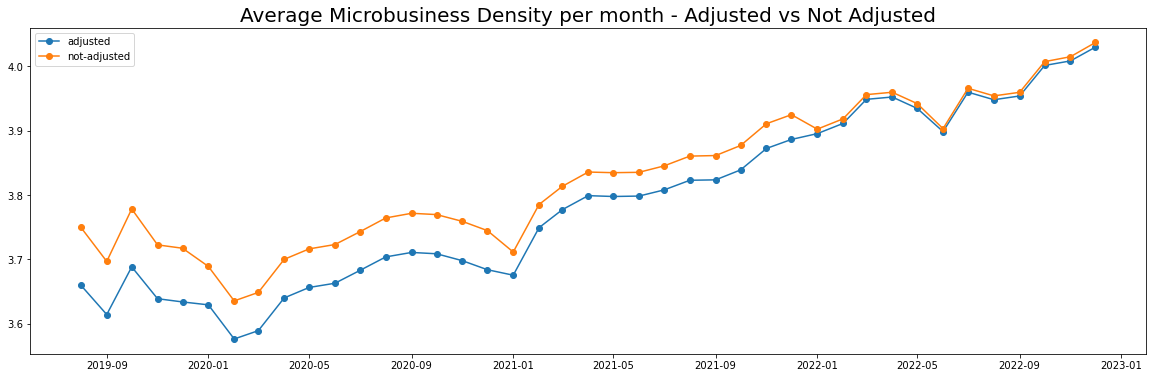

In [8]:
# PLOT AVERAGE MD PER MONTH
tmp2 = train.groupby('first_day_of_month').microbusiness_density.mean()
plt.figure(figsize=(20,6))
plt.plot(tmp2.index, tmp2,'-o', label='adjusted')
plt.plot(tmp.index, tmp,'-o', label='not-adjusted')
plt.title('Average Microbusiness Density per month - Adjusted vs Not Adjusted',size=20)
plt.legend()
plt.show()

## Find Large County Populations
We will train our model on large county populations only. We will use the top 90% quantile and ignore the bottom 10% during training. (For inference we will use last value baseline for bottom 10%). We will also remove outliers where microbusiness density exceeds 50%.


In [9]:
QUANT = 0.1
THRESH = 50

train['pop'] = (100 * train.active / train.microbusiness_density).round()
train['m'] = train.groupby('cfips').microbusiness_density.transform('max')

c = train.adult2021.quantile(q=QUANT)
# large population region
KEEP = train.loc[(train.adult2021>=c)&(train.m<THRESH),'cfips'].unique()
print('We will train with', len(KEEP),'large counties')

We will train with 2814 large counties


In [10]:
# small population region
SMALL = train.cfips.nunique() - len(KEEP)
print('There are ',SMALL,'small counties')

There are  321 small counties


## Prepare Train Data
Each county has 41 months of history data from August 2019 thru Dec 2022. We will train our models with Feb 2020 thru Dec 2022 only. This is 35 months. For each county, we will break this 1 time series of 35 months into 18 time series of 18 months.

For example, the first time series window will be Feb 2020 thru and including July 2021. This is 18 months. The model will train on the first 13 months of this sample and predict the last 5 months. The last time series window will be July 2021 thru and including Dec 2022. This is 18 months. The model will train on the first 13 months of this sample and predict the last 5 months.

Within each time window, the data of the time series may be different because they correspond to different time periods. For example, the first time window might contain data from February 2020 to July 2021, the second time window might contain data from March 2020 to August 2021, and so on.

Because each time window has a different start and end time, the data within the time series will also vary. Such a design can help the model capture changes and trends in different time periods, thereby improving the model's ability to understand and predict time series data.

## Small County Data
We will save small county data in a variables named x_data2 and y_data2. During inference, we will just use last value baseline to predict small counties

In [12]:
TOTAL_MONTHS = 41
WIDTH = 35

data2 = train.loc[~train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((SMALL, TOTAL_MONTHS))[:,-1*WIDTH:]
print('Small county data has shape',data2.shape)

Small county data has shape (321, 35)


In [13]:
COPIES = 18

y_data2 = np.zeros((321*COPIES,3))
x_data2 = np.zeros((321*COPIES,1))
for j in range(321):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data2[i,] = data2[j,k+(WIDTH-COPIES-5)] # LAST MONTH OF 13 MONTH TRAIN （Baseline）
        y_data2[i,] = data2[j,k+(WIDTH-COPIES-2):k+(WIDTH-COPIES+1)] # LAST 3 MONTHS OF 5 MONTH PREDICT
x_data2.shape, y_data2.shape

((5778, 1), (5778, 3))

In [14]:
COPIES = 18

y_data2 = np.zeros((321*COPIES,3))
x_data2 = np.zeros((321*COPIES,1))
for j in range(321):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data2[i,] = data2[j,k+(WIDTH-COPIES-5)] # LAST MONTH OF 13 MONTH TRAIN
        y_data2[i,] = data2[j,k+(WIDTH-COPIES-2):k+(WIDTH-COPIES+1)] # LAST 3 MONTHS OF 5 MONTH PREDICT
x_data2.shape, y_data2.shape

((5778, 1), (5778, 3))

## Large County Data
We will store large county data in NumPy variables x_data and y_data. And eventually put it into Pandas dataframe train_data.

In [18]:
data = train.loc[train.cfips.isin(KEEP)]\
    .microbusiness_density.values.reshape((len(KEEP), TOTAL_MONTHS))[:,-1*WIDTH:]
print('Large county data has shape',data.shape) 
# Each row represents a county-level area with a large population, 
# and each column represents the microenterprise density value at a point in time

Large county data has shape (2814, 35)


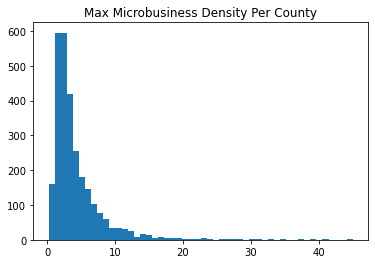

In [19]:
plt.hist( np.max(data,axis=1),bins=50 ) # Indicates to take the maximum value in each row of the data array
plt.title('Max Microbusiness Density Per County')
plt.show()

In [20]:
# Initialize
x_data = np.zeros((len(KEEP)*COPIES, WIDTH-COPIES-4)) # X_TRAIN TIME SERIES ARE 13 MONTHS
y_data = np.zeros((len(KEEP)*COPIES, 5)) # Y_TRAIN TIME SERIES ARE 5 MONTHS
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

In [21]:
# Set train value
for j in range(len(KEEP)):
    for k in range(COPIES):
        i = j*COPIES + k
        x_data[i,] = data[j,k:k+(WIDTH-COPIES-4)]
        y_data[i,] = data[j,k+(WIDTH-COPIES-4):k+(WIDTH-COPIES+1)]

In [22]:
x_data.shape, y_data.shape

((50652, 13), (50652, 5))

## Convert Train Data to ratios
We will now convert the raw microbusiness density values in train data to ratio values. We will replace each month's microbusiness density by the ratio of current month divided by past month. Our model will train with and learn to predict this ratio for each month (instead of predicting the raw microbusiness density values).

After converting our train data, our X_train will now be time series of length 12 instead of 13. (And y_train will remain timeseries of length 5).

In [24]:
x_data3 = x_data.copy()
y_data3 = y_data.copy()

In [25]:
# CONVERT TO RATIOS
for k in range(WIDTH-COPIES-5):
    x_data3[:,k+1] = x_data[:,k+1] / x_data[:,k]

In [26]:
# CONVERT TO RATIOS
x_data3 = x_data3[:,1:][:,0] = y_data[:,0] / x_data[:,-1]
for k in range(4):
    y_data3[:,k+1] = y_data[:,k+1] / y_data[:,k]

In [27]:
y_data3.shape

(50652, 5)

In [28]:
x_data3 = x_data3[:,1:] # The data in the first column are raw microenterprise density values, not ratio values

In [29]:
# STANDARIZE
# The standardization operation uses zero-mean standardization (Z-score standardization)
# Through normalization, we can adjust the input data and output data to the same scale for better model training and prediction.
mn = np.mean(x_data3)
sd = np.std(x_data3)
x_data3 = (x_data3 - mn)/sd
y_data3 = (y_data3 - mn)/sd
print('Average ratio =',mn,'and Average std =', sd)

Average ratio = 1.002049802661262 and Average std = 0.049110348928488375


## Finalize Train Data and Display
We will put the NumPy arrays into a Pandas dataframe. And we will display some train samples.

In [31]:
FEATURES = [f'f{x}' for x in range(WIDTH-COPIES-4-1)]
TARGETS = [f'y{x}' for x in range(5)]
train_data = pd.DataFrame(x_data3,columns=FEATURES)
train_data[TARGETS] = y_data3
train_data['cfips'] = np.repeat(KEEP,COPIES)
print('Our GRU training data has shape:', train_data.shape )
train_data.head(20)

Our GRU training data has shape: (50652, 18)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,y0,y1,y2,y3,y4,cfips
0,0.125577,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,1001
1,0.422927,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,1001
2,-0.009290,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,1001
3,0.055457,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,1001
4,0.393560,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,1001
5,0.558081,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,0.501256,1001
6,0.157591,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,0.501256,0.178632,1001
7,-0.117661,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,0.501256,0.178632,0.190807,1001
8,-1.032420,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,0.501256,0.178632,0.190807,-0.027368,1001
9,-0.282048,-0.252495,1.055827,0.206961,0.480372,-0.026766,-0.071662,-0.116655,0.018416,-0.251660,0.064315,-0.056810,0.501256,0.178632,0.190807,-0.027368,0.173659,1001


In [32]:
FEATURES, TARGETS

(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'],
 ['y0', 'y1', 'y2', 'y3', 'y4'])

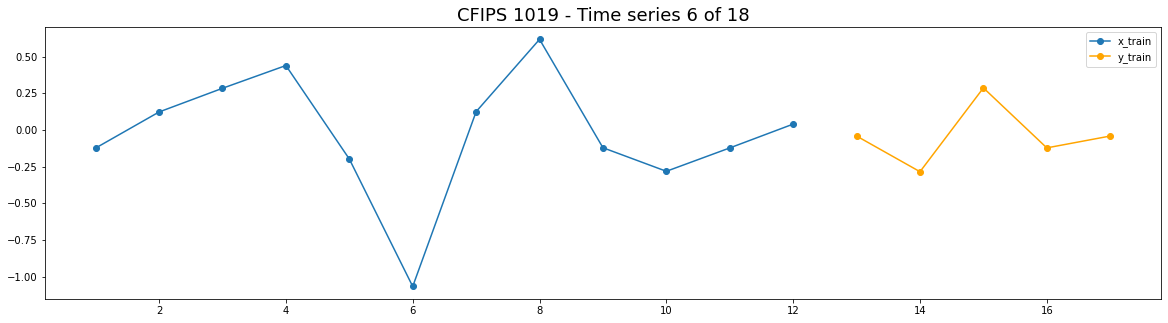

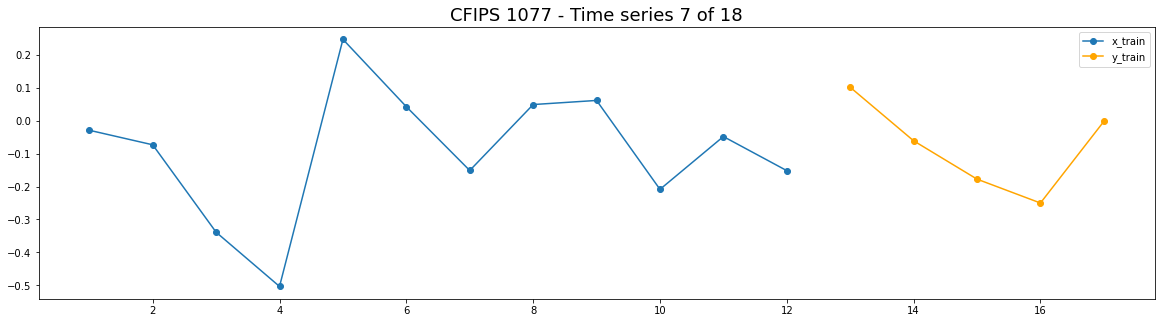

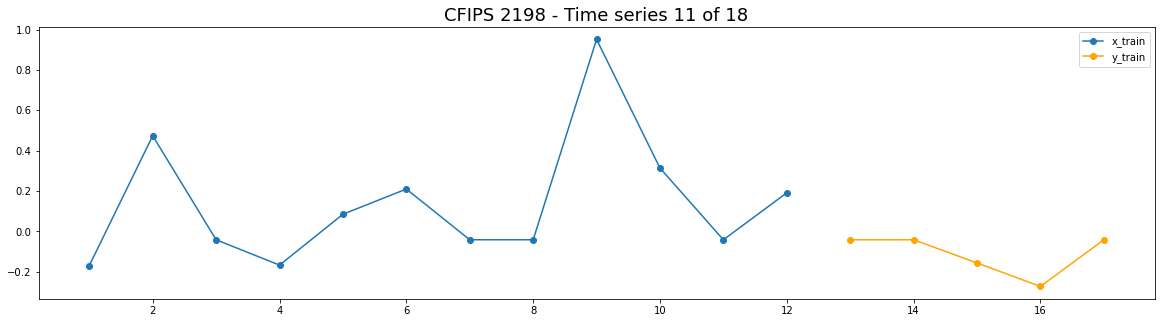

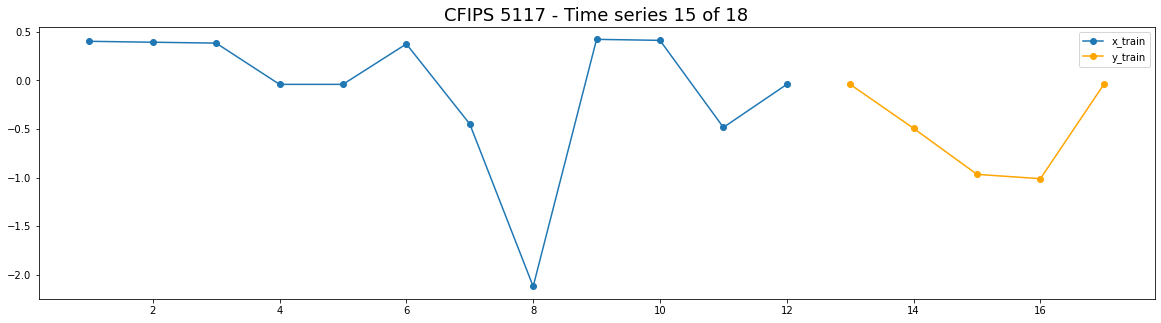

In [37]:
for k in range(4):
    j = np.random.choice(np.arange(len(x_data2))) # minimize CFIPS
    
    row = j//COPIES
    col = j%COPIES
    
    plt.figure(figsize=(20,5))
    x = np.arange(WIDTH-COPIES-4-1)+1 # Adjust the index value from 0 to 1 with the +1 operation to more closely match the time unit of the time series.
    plt.plot(x,x_data3[j,],'-o',label='x_train')
    plt.plot([WIDTH-COPIES-4,WIDTH-COPIES-3,WIDTH-COPIES-2,WIDTH-COPIES-1,WIDTH-COPIES],y_data3[j,],
             '-o',color='orange',label='y_train')   
    plt.title(f'CFIPS {KEEP[row]} - Time series {col} of {COPIES}',size=18)
    plt.legend()
    plt.show()

In [38]:
train_data.to_csv('train_data.csv', index=False)